# Tarea 1 - Árboles de Decisión

### Grupo 8:
     - Matías González 5199522-2
     - Leonardo Melgar 5206567-4
     - Emiliano Silva 5127389-8


## 1. Objetivo

Este laboratorio tiene por objetivos:

a) implementar el algoritmo ID3 con la extensión para atributos numéricos

b) el uso de scikit-learn para el preprocesamiento de datos y la creación de modelos basados en árboles de decisión

c) la evaluación de los modelos generados.



## 2. Diseño

## 2.1 Preprocesamiento de datos
Primeramente comenzamos importando las librerias *pandas*, *numpy*, algunos módulos de *scikit-learn* y además el codigo implementado para la resolución del problema, debido a que estaremos aprovechando sus utilidades durante el transcurso de este documento:

In [ ]:
import pandas
import numpy
from sklearn import ensemble, model_selection, metrics, tree
from lab1 import *

Una vez importadas estas utilidades, comenzamos cargando el archivo CSV que contiene los datos que se estáran utilizando para el entrenamiento y testeo de los distintos modelos que serán presentados. Para esto utilizaremos la librería *pandas* que nos permite cargar el dataset a partir de archivos en este formato. Además, al dataset leido, le hemos quitado el atributo *pidnum* ya que este únicamente tiene la utilidad de identificar a cada fila del conjunto de datos, pero no aporta información relevante para el modelo:

In [ ]:
# Cargar el archivo CSV
dataset = pandas.read_csv('lab1_dataset.csv')
dataset = dataset.drop('pidnum', axis='columns')

# Definir los atributos y el atributo objetivo
attributes = dataset.columns.values.tolist()
attributes.remove('cid')
target_attribute = 'cid'
mcv = most_common_value(dataset, target_attribute)


Definimos además como atributo objetivo al atributo *cid*.

Debido a que algunos de los atributos numéricos utilizados van a tener en su valor una variabilidad muy alta (como pueden ser valores continuos, o datos como la edad), se “partirán” en rangos los atributos que cumplan con estas características. Se utilizará el hiperparametro max_range_split para determinar la cantidad máxima de rangos en los que se puede partir un atributo numérico.

Esta separación en rangos se realizará en dos momentos distintos de la ejecución del algoritmo ID3 que veremos a continuación. Primero se realizará durante la ejecución del algoritmo, en los momentos que se transcurra por los atributos correspondientes. Y también probaremos realizar esta separación antes de ejecutarlo (es decir, pre procesaremos los datos), en lugar de hacerlo durante la ejecución. Esto con el fin de comparar la performance que tiene este reajuste en los datos.

Los atributos que corresponde separar en rangos debido a la naturaleza de sus valores son *time, age, wtkg, karnof, preanti, cd40, cd420, cd80* y *cd820*.

## 2.2 Algoritmo


Nuestro algoritmo ID3 (implementado por la función llamada id3) recibe como parámetros el dataset, los atributos que nos interesa evaluar en el algoritmo, el atributo objetivo, el hiper parámetro max_range_split y uno extra llamado parent_node_class, el cual no debe ser enviado al utilizar la función externamente, ya que es un parámetro que usa internamente la función id3 misma (más adelante explicaremos como). El árbol que nos devuelve esta función está representado por una estrucutura de elementos de tipo “dict” anidados, de la siguiente forma:

\

\{ atributo_1: \{ v1: \{ .. }, v2: \{ .. }, v3: \{ .. }, …, vn: \{ .. } } }

\

”atributo_1” es el atributo que fue seleccionado como el que debe ir en la raíz del arbol. Las claves v1, v2, … vn son los valores del "atributo_1" que se encontraban en el dataset en el momento que empezó el algoritmo. Para cada valor que se encuentra como clave luego del atributo le puede corresponder un nuevo dict que tiene la misma forma (con un nuevo atributo y sus valores) o una hoja del árbol (las cuales son representadas por el valor 0 o 1).
Un detalle a tener en cuenta es que para aquellos atributos que no son considerados “categóricos” en vez de almacenar valores, se almacenaron los intervalos en un string de esta forma: “extremo1 extremo2”. De esta manera, cuando una muestra intenta ser predecida por nuestro árbol y se llega al momento de evaluar un atributo no categórico, se evalúa a qué intervalo pertenece y se procede por esa rama (tener en cuenta que el intervalo se evalúa de esta forma: extremo1 < atributo_evaluado <= extremo2).


### 2.2.1 Casos base


Nuestra implementación evalúa los dos casos base del algoritmo:


Si todos los ejemplos tienen el mismo valor → etiquetar con ese valor
Si no me quedan atributos → etiquetar con el valor más común


Para etiquetar con el valor más común es que utilizamos el atributo de la función id3 llamado parent_node_class. Como ya estamos en un nivel inferior del árbol (ni siquiera sabemos qué valor se asignó como padre) pasamos como parámetro el valor más común del dataset en la iteración anterior, y si no nos quedan atributos procedemos a asignar ese valor a la hoja.


### 2.2.2 Elección de best_attribute


Para elegir el mejor atributo para continuar armando el árbol utilizamos aquel que proporciona la mayor ganancia de información a través de la función best_attribute_to_split. Esta recibe como parámetros el dataset con las columnas de atributos que quedan hasta el momento de la recorrida y los valores que obtiene cada row en el atributo objetivo. Una vez elegido el best_attribute procedemos a asignarlo como nodo en el arbol. Si el atributo es categórico (es decir, no pertenece al array ATTRIBUTES_REQUIRING_RANGES, el cual posee los atributos que consideramos no categóricos), procedemos a agregar como nodo cada valor de los que quedan en el dataset para ese atributo y llamar recursivamente a la función id3.


### 2.2.3 Manejo de atributos no categóricos


Como mencionamos anteriormente, si best_attribute es un atributo no categórico, procedemos a agregar como nodos los rangos que determinamos en este momento del algoritmo. Para ello primero evaluamos todos los posibles cortes, ordenando de menor a mayor (en base al best_attribute) las filas del dataset y procedemos a tomar como posibles cortes aquellos que están entre medio de dos filas que cambian su valor de 0 a 1 o viceversa. Luego, si max_range_split es 2 tomamos el primer corte y si max_range_split es 3 tomamos el primer y el último corte (esta elección fue hecha por motivos de eficiencia, pero se pueden tomar otras alternativas más efectivas a la hora de predecir).
Una vez que realizamos este proceso, asignamos el intervalo en el nodo (poniendo el string con ambos extremos) y llamamos a id3 con el dataset cuyos valores en best_attribute pertenecen a dicho intervalo.


Se debe tener en cuenta que si a id3 se le pasa el atributo max_range_split como 0, se considerará que todos los atributos son categóricos.


### 2.2.4 Predicción de una muestra con el modelo devuelto por ID3


Se implementó una función llamada predict_id3, la cual se le debe proveer un árbol generado por nuestra implementación de ID3 y una muestra que se quiere predecir su valor en el atributo objetivo. Esta función va recorriendo el árbol y evaluando por cual rama se debe continuar, hasta llegar a una hoja, la cual tendrá el valor que predice para esa muestra. Si en algún caso ninguna de las ramas posee el valor de la muestra en un atributo se le asigna el valor del atributo objetivo más común.







## 2.3 Evaluación

Al momento de la evaluación se tomará como métrica la *accuracy* (o exactitud), la cual nos indica la proporción de predicciones correctas. Para su calculo se toma de nuestro conjunto de datos, un subconjunto de prueba (menor al subconjunto de entrenamiento), y se compara para esa muestra la predicción realizada por el modelo con el valor en el atributo objetivo original.

## 3. Experimentación

## 3.1 Algorimo ID3 sin preprocesamiento
Comenzaremos con el algoritmo ID3 presentado en la sección 2.2, para el cual probaremos con el hiperparametro max_range_split con los valores 2 y 3.

Para comenzar, ciertos valores de nuestro dataset deben ser tomados para entrenar a nuestro modelo mientras que el resto serán utilizados para probar el modelo resultante.

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
dataset_train, dataset_test, target_train, target_test = model_selection.train_test_split(dataset[attributes], dataset[target_attribute], test_size=0.2, random_state=42)
dataset_train_for_id3 = pandas.concat([dataset_train, target_train], axis=1)

Ejecutamos entonces el algoritmo ID3 para el dataset de entrenamiento:

In [ ]:
# ID3 sin preprocesado y con max_range_split 2

max_range_split = 2
print(f"ID3 sin preprocesado y max_range_split = {max_range_split}")
tree_id3 = id3(dataset_train_for_id3, attributes, target_attribute, max_range_split)
accuracy = evaluate_id3_model(tree_id3, dataset_test, target_test, mcv, True)
print(f"Accuracy: {accuracy}")

ID3 sin preprocesado y max_range_split = 2
Accuracy: 0.735981308411215


Primero que nada observamos que los resultados obtenidos para un max_range_split de 2 da una accuracy de 0.73. Lo cual nos indica que el modelo suele tener aciertos en la gran mayoría de pruebas.

Aún así, podemos ver que si probamos con un max_range_split de 3, obtenemos mejores resultados:

In [ ]:
max_range_split = 3
print(f"ID3 sin preprocesado y max_range_split = {max_range_split}")
tree_id3 = id3(dataset_train_for_id3, attributes, target_attribute, max_range_split)
accuracy = evaluate_id3_model(tree_id3, dataset_test, target_test, mcv, True)
print(f"Accuracy: {accuracy}")

ID3 sin preprocesado y max_range_split = 3
Accuracy: 0.794392523364486


Esta mejora al aumentar el valor de max_range_split de 2 a 3 la podemos atribuir a que el algoritmo ID3 tiene más flexibilidad para dividir los atributos numéricos en rangos más finos, lo que permite al modelo capturar mejor las relaciones entre las características y la variable objetivo. Es decir, el  max_range_split tiene menos libertad para adaptarse a los datos, ya que solo puede dividirse en dos grupos de valores para ese atributo, mientras que agregar rangos permite que se asocien con mayor precisión los posibles rangos de valores a los valores de la función objetivo.

Es importante aun así, tener en cuenta que incrementar demasiado el valor de max_range_split también puede traer desventajas como aumentar la complejidad del árbol (lo que puede hacerlo menos interpretable), y también puede llevar a que el modelo se ajuste demasiado a los datos de entrenamiento y no generalice bien en datos nuevos.

## 3.2 Algorimo ID3 con preprocesado
Veamos ahora qué ocurre cuando utilizamos max_range_split para preprocesar nuestro dataset, es decir, dividir ciertos atributos en rangos antes de aplicar el algoritmo ID3 (en lugar de hacerlo mientras lo ejecutamos). Observemos primero con max_range_split = 2:

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba CON PREPROCESADO
max_range_split = 2

dataset_sp = preprocessing_with_max_range_split(dataset, max_range_split) # Se preprocesa el dataset con max_range_split

dataset_train_sp, dataset_test_sp, target_train_sp, target_test_sp = model_selection.train_test_split(dataset_sp[attributes], dataset_sp[target_attribute], test_size=0.2, random_state=42)
# Se determinan los conjuntos que son para entrenamiento (ya que sus valores cambiaron para ciertos atributos)
dataset_train_for_id3_sp = pandas.concat([dataset_train_sp, target_train_sp], axis=1)

# Ejecutamos el ID3 con los datos preprocesados
print(f"ID3 con preprocesado y max_range_split = {max_range_split}")
tree_id3 = id3(dataset_train_for_id3_sp, attributes, target_attribute)
accuracy = evaluate_id3_model(tree_id3, dataset_test, target_test, mcv, False)
print(f"Accuracy: {accuracy}")

ID3 con preprocesado y max_range_split = 2
Accuracy: 0.7476635514018691


Y veamos también con max_range_split = 3:

In [ ]:
max_range_split = 3
dataset_sp = preprocessing_with_max_range_split(dataset, max_range_split) # Se preprocesa el dataset con max_range_split

dataset_train_sp, dataset_test_sp, target_train_sp, target_test_sp = model_selection.train_test_split(dataset_sp[attributes], dataset_sp[target_attribute], test_size=0.2, random_state=42)
# Se determinan los conjuntos que son para entrenamiento (ya que sus valores cambiaron para ciertos atributos)
dataset_train_for_id3_sp = pandas.concat([dataset_train_sp, target_train_sp], axis=1)

# Ejecutamos el ID3 con los datos preprocesados
print(f"ID3 con preprocesado y max_range_split = {max_range_split}")
tree_id3 = id3(dataset_train_for_id3_sp, attributes, target_attribute)
accuracy = evaluate_id3_model(tree_id3, dataset_test, target_test, mcv, False)
print(f"Accuracy: {accuracy}")

ID3 con preprocesado y max_range_split = 3
Accuracy: 0.764018691588785


Lo primero que podemos notar es que al igual que como ocurría anteriormente, cuando aumentamos max_range_split tenemos una mejora en el accuracy. Esto ocurre por la misma razón que se mencionó en la sección anterior.

Lo siguiente que debemos observar es que los resultados de preprocesar previamente con max_range_split tienen menor accuracy que los que obtenemos si aplicamos max_range_split durante la ejecución del algoritmo ID3. Para entender a que se debe esto, observamos que en el preprocesamiento, los rangos para los atributos que fueron separados se determinan teniendo en cuenta todo el conjunto de datos, antes de entrenar el árbol, mientras que en el caso de ID3 sin preprocesar, los puntos de corte y los rangos se determinan dinámicamente en cada nodo del árbol que corresponde a esos atributos, considerando aquí solo las filas que llegan hasta ese nodo (que pueden ser un subconjunto de los valores originales del dataset). Estos puntos de corte se eligen cuando el atributo se consideró el mejor para dividir el nodo (mediante la función best_attribute_to_split).

Es decir, en el preprocesamiento, cuando se ejecuta ID3, el algoritmo trabaja con los atributos ya convertidos en rangos, esto es diferente a ejecutarlo sin preprocesar, donde el algoritmo considera todos los valores posibles del atributo y solo separa al atributo en rangos recién al momento de que este fue elegido como "el mejor". Como resultado, los árboles obtenidos pueden ser diferentes dependiendo de si se preprocesan los datos o no, obteniendo mejores resultados si aplicamos la separación con max_range_split durante la ejecución del algoritmo.

## 3.3 DecisionTreeClassifier

In [ ]:
print("DecisionTreeClassifier random_state=42")
dtc_model_1 = tree.DecisionTreeClassifier(random_state=42)
train_sklearn_model(dtc_model_1, dataset_train, target_train)
accuracy_1 = evaluate_sklearn_model(dtc_model_1, dataset_test, target_test)
print(f"Accuracy: {accuracy_1}")

print("DecisionTreeClassifier max_depth=5, min_samples_split=4, min_samples_leaf=2")
dtc_model_2 = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=4, min_samples_leaf=2, random_state=42)
train_sklearn_model(dtc_model_2, dataset_train, target_train)
accuracy_2 = evaluate_sklearn_model(dtc_model_2, dataset_test, target_test)
print(f"Accuracy: {accuracy_2}")

DecisionTreeClassifier random_state=42
Accuracy: 0.8504672897196262
DecisionTreeClassifier max_depth=5, min_samples_split=4, min_samples_leaf=2
Accuracy: 0.8714953271028038


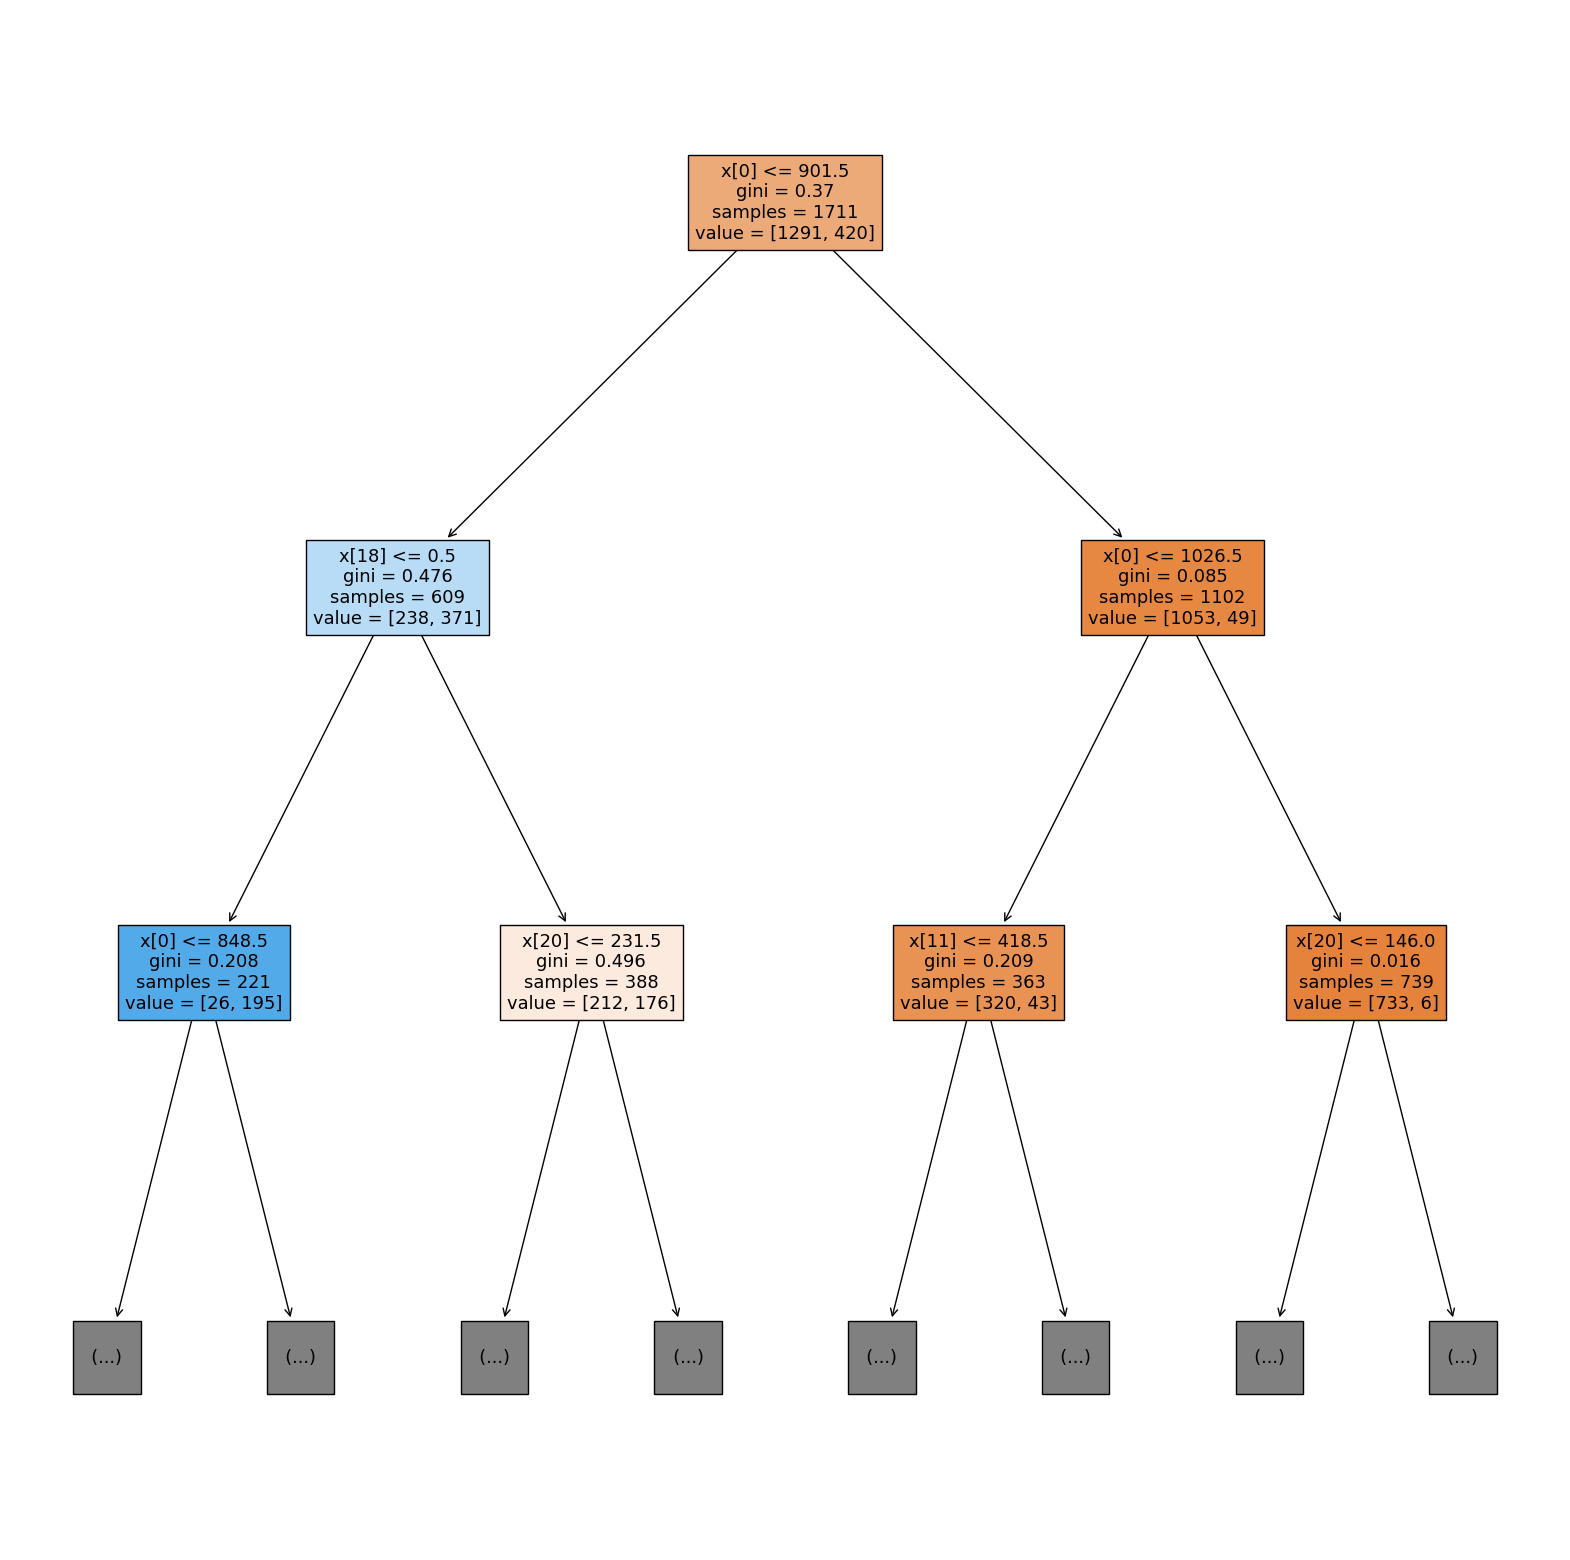

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
tree.plot_tree(dtc_model_2, filled=True, max_depth=2)
plt.show()

Vemos como con DecisionTreeClassifier se obtiene una accuracy de aproximadamente **0.850**, con los paramétros por defecto, mejorando el rendimiento de ID3. La mejora es esperable dado que DecisionTreeClassifier cuenta con:

- **Criterio de División Mejorado**: utilizando el índice de Gini (por defecto en scikit-learn) para reducir impurezas y más optimizaciones con respecto a ID3
- Cuenta con técnicas de **poda** de árboles para evitar el overfitting
- Manejo de **atributos continuos** sin necesidad de discretizacion, datos más cercanos a la realidad
- Más **eficiencia y optimización**
- **Soporte para datos desbalanceados**, permite ajustar pesos de cada clase (no fue utilizado en este caso)
- Mecanismos para **limitar la profunidad** del arbol y **número mínimo de muestras en las hojas**, para volverlo mas general

mientras que ID3 es una versión mas simple.


### DecisionTreeClassifier cuenta con hiperparámetros los cuales modificamos para obtener una mejora en accuracy:

- **max_depth=5** para limitar la profundidad del árbol, esto simplifica el modelo, mejorando la capacidad de generalización, resultando en una mejor precisión.

- **min_samples_split=6** especifica el número mínimo de muestras requeridas para dividir un nodo interno, cuanto mayor sea este valor el modelo va a necesitar mas datos para crear una nueva rama con lo que prevenimos divisiones basadas en patrones débiles.

- **min_samples_leaf=2** es el número mínimo de muestras que una hoja debe contener evitando hojas con pocos datos, requerir al menos dos muestras por hoja asegura ramas más estables y representativas.

Los hiperparámetros fueron ajustados mediante un método de Grid Search que prueba diferentes combinaciones de valores para encontrar la mejor y utiliza **validación cruzada** para evaluar el rendimiento. Esto permitió seleccionar los valores óptimos para maximizar el rendimiento del modelo y evitar overfitting.

## 3.4 RandomForestClassifier

In [ ]:
print("RandomForestClassifier")
rfc_model_1 = ensemble.RandomForestClassifier(random_state=42)
train_sklearn_model(rfc_model_1, dataset_train, target_train)
accuracy_1 = evaluate_sklearn_model(rfc_model_1, dataset_test, target_test)
print(f"Accuracy: {accuracy_1}")

print("RandomForestClassifier n_estimators=200, max_depth=10, max_features='sqrt'")
rfc_model_2 = ensemble.RandomForestClassifier(n_estimators=200, max_depth=10, max_features='sqrt', random_state=42)
train_sklearn_model(rfc_model_2, dataset_train, target_train)
accuracy_2 = evaluate_sklearn_model(rfc_model_2, dataset_test, target_test)
print(f"Accuracy: {accuracy_1}")

RandomForestClassifier
Accuracy: 0.8785046728971962
RandomForestClassifier n_estimators=200, max_depth=10, max_features='sqrt'
Accuracy: 0.8785046728971962


Nuevamente se obtienen mejores resultados que el caso anterior, esta vez al rededor de **0.879** de accuracy. Es un resultado esperable ya que RandomForestClassifier tiene:

- **Reducción de overfitting** con respecto a los otros algoritmos que utilizan un único árbol al promediar/relacionar múltiples árboles
- Cada árbol es entrenado con un subconjunto diferente de datos por lo que hay una gran **diversidad** y es mas general
- Al igual que DecisionTreeClassifier cuenta con manejo de **atributos continuos** y la posiblidad de ajustar **hiperparámetros** para mejorar la accuracy.

### Hiperparámetros:

- **n_estimators=200** (= m cantidad de árboles) para incrementar el número de árboles en el bosque de 100 (default) a 200 ya que al tener más árboles el modelo se vuelve más robusto y estable por lo que reduce la varianza y mejora la generalización

- **max_depth=10**  al igual que en DecisionTreeClassifier se modificó la profundidad máxima

- **max_features='sqrt'** (= p cantidad de atributos) limita el número máximo de características consideradas para dividir en cada nodo a la raiz cuadrada (sqrt) de la cantidad total de características, reduciendo la correlación entre árboles y mejorando la generalización

Se obtuvieron los valores utilizando el mismo método que en DecisionTreeClassifier con ligeras modificaciones para adaptarlo a RandomForestClassifier.

## 3.5 Accuracy en función de test_size


Se evaluará el rendimiento de los modelos en función del valor de test_size que determina la proporción del conjunto de entrenamiento. Para ello se tomarán diferentes valores de test_size como referencia, a continuación los presentamos:

- 10-20%, para datasets pequeños se suelen utilizar valores pequeños de test_size para entrenar el modelo con la mayor cantidad de datos posible

- 20-30%, son proporciones comunmente utilizadas, es más *train_test_split* de scikit-learn utiliza 0.25 como el valor por defecto para test_size. Da suficiente cantidad de datos al conjunto de entrenamiento sin dejar un conjunto de prueba pequeño.

- 30-40%, se toman valores mayores cuando se cuenta con una gran dataset para tener una mejor evaluación.

In [ ]:
results_id3 = []
results_id3_sp = []
results_dtc = []
results_rfc = []
test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40]

for test_size in test_sizes:
    # Dividir los datos en conjunto de entrenamiento y prueba con el tamaño especificado
    dataset_train, dataset_test, target_train, target_test = model_selection.train_test_split(dataset[attributes], dataset[target_attribute], test_size=test_size, random_state=42)
    dataset_train_for_id3 = pandas.concat([dataset_train, target_train], axis=1)

    # Dataset Preprocesado
    max_range_split = 3
    dataset_sp = preprocessing_with_max_range_split(dataset, max_range_split)
    dataset_train_sp, dataset_test_sp, target_train_sp, target_test_sp = model_selection.train_test_split(dataset_sp[attributes], dataset_sp[target_attribute], test_size=0.2, random_state=42)
    dataset_train_for_id3_sp = pandas.concat([dataset_train_sp, target_train_sp], axis=1)

    # Entrenar los modelos y evaluar
    tree_id3 = id3(dataset_train_for_id3, attributes, target_attribute, max_range_split)
    accuracy_id3 = evaluate_id3_model(tree_id3, dataset_test, target_test, mcv, True)

    tree_id3_sp = id3(dataset_train_for_id3_sp, attributes, target_attribute)
    accuracy_id3_sp = evaluate_id3_model(tree_id3_sp, dataset_test, target_test, mcv, False)

    dtc_model = tree.DecisionTreeClassifier(random_state=42)
    train_sklearn_model(dtc_model, dataset_train, target_train)
    accuracy_dtc = evaluate_sklearn_model(dtc_model, dataset_test, target_test)

    rfc_model = ensemble.RandomForestClassifier(random_state=42)
    train_sklearn_model(rfc_model, dataset_train, target_train)
    accuracy_rfc = evaluate_sklearn_model(rfc_model, dataset_test, target_test)

    # Guardar los resultados
    results_id3.append(accuracy_id3)
    results_id3_sp.append(accuracy_id3_sp)
    results_dtc.append(accuracy_dtc)
    results_rfc.append(accuracy_rfc)

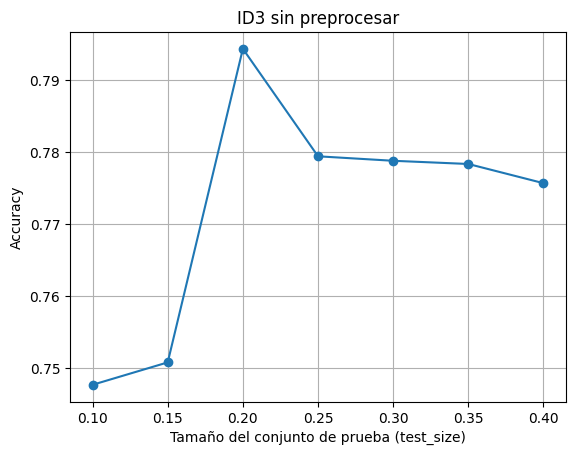

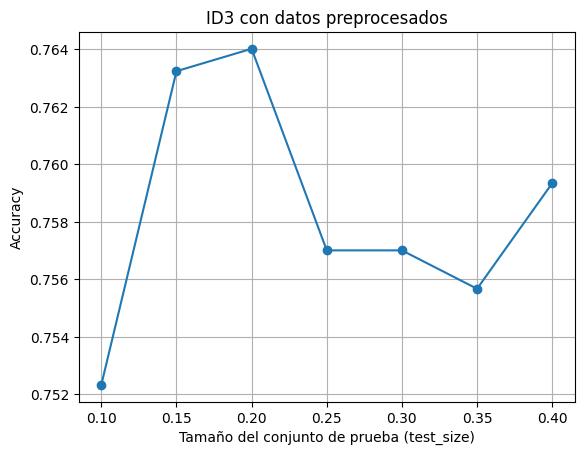

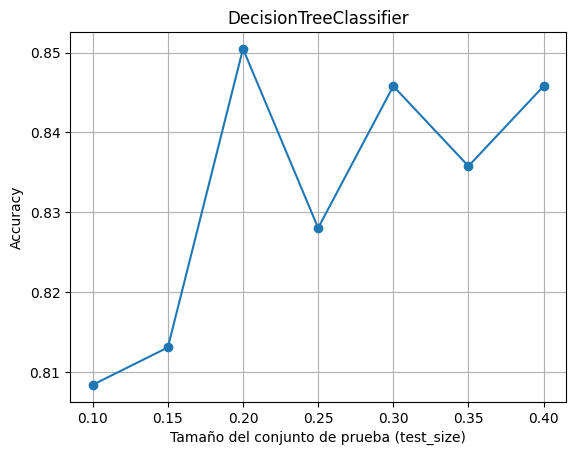

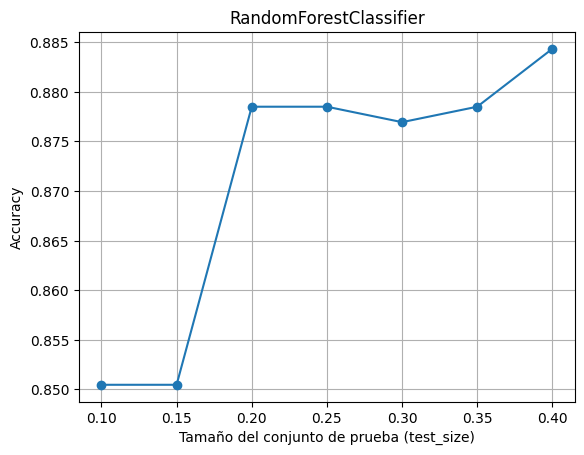

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_sizes, results_id3, marker='o')
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('Accuracy')
plt.title('ID3 sin preprocesar')
plt.grid(True)
plt.show()

plt.plot(test_sizes, results_id3_sp, marker='o')
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('Accuracy')
plt.title('ID3 con datos preprocesados')
plt.grid(True)
plt.show()

plt.plot(test_sizes, results_dtc, marker='o')
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('Accuracy')
plt.title('DecisionTreeClassifier')
plt.grid(True)
plt.show()

plt.plot(test_sizes, results_rfc, marker='o')
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('Accuracy')
plt.title('RandomForestClassifier')
plt.grid(True)
plt.show()

Cuanto más complejo el modelo mejor rendimiento se obtiene, siendo RandomForestClassifier el mejor y además con menos fluctuaciones en los resultados.

Vemos que en los 4 modelos se obtuvo una buena accuracy para **test_size=0.20**, siendo el máximo en todos menos RandomForestClassifier el cual alcanza su pico en 0.40. Es un valor comúnmente utilizado dado el balance entre la cantidad de datos del conjunto de entrenamiento y evaluación.

Esto nos lleva a elegir este valor de test_size para tomar como referencia.

## 4. Conclusión


Entre los 3 algoritmos (ID3, DecisionTreeClassifier y RandomForestClassifier) el algoritmo ID3 fue el que obtuvo peor exactitud de todos. Probablemente el hecho de que ID3 no esté preparado para soportar atributos continuos es uno de los principales factores, ya que estamos realizando una adaptación (que incluso en nuestra implementación no es de las más óptimas debido a motivos de eficiencia) para que los atributos no categóricos se comporten como tales.
Otro posible factor influyente es que DecisionTreeClassifier y RandomForestClassifier reducen la posibilidad de overfitting a través de diferentes técnicas. En nuestra implementación de ID3 puede ocurrir que en algún momento de la ejecución se agregan varias ramas (por la presencia de varios valores del best_attribute en el dataset) y no contamos con ninguna técnica para revertirlo.

Con respecto a la experimentación con diferentes tamaños de conjuntos de prueba, cuando el 20% del dataset fue utilizado fue cuando se obtuvo el mejor resultado en términos de exactitud. Sin embargo, al variar este tamaño entre 10% y 55% las diferencias que se obtuvieron no fueron significativas, por lo que no podemos lograr conclusiones muy determinantes.

La diferencia que se observó entre las ejecuciones del algoritmo ID3 pre procesando los datos y no pre procesándolos es que los resultados mejoran al momento de separar en rangos los atributos durante la ejecución del algoritmo en lugar de realizarlo previo a la ejecución del algoritmo y el motivo que creemos que es el principal es la reducción en la cantidad de datos que se consideran al momento de determinar los rangos, ya que en el caso que se determinan durante la ejecución se hace a partir de un subconjunto datos (en lugar del total) y por lo tanto, los rangos son tomados con mayor precisión, haciendo que se ajusten y asocien mejor los valores del atributo al objetivo.

La principal mejora que le haríamos a nuestra implementación del algoritmo ID3 es la aplicación de una mejor técnica para la elección de los mejores cortes. Como se explica en la sección “Algoritmo”, luego de elegir los cortes candidatos, nos quedamos con el primero y el último (o solo con el primero en caso de que max_range_split sea 2). En vez de elegirlos de esta forma, podría calcularse cuales son los mejores cortes evaluando la ganancia de información.
